# Keras CNN Baseline with stock embedding

#### A 1D CNN baseline with stock id embedding implemented in Keras.

> Embedding idea from: https://www.kaggle.com/colinmorris/embedding-layers / 
 https://www.kaggle.com/lucasmorin/tf-keras-nn-with-stock-embedding

> Very useful preprocessing functions for CNN, and great CNN implementation:
https://www.kaggle.com/slawekbiel/deep-learning-approach-with-a-cnn-inference


#### The main differences here to previous CNN attempts are 
- stock embedding
- extra features (wap, log return, bid / ask spread)
- simple cnn architecture (dropout / pooling didnt seem to improve results)
- no trade data, just book data
- reduced image size, taking every 4th second

I have also made an effort to manage memory usage so that the model can be trained without a generator.

#### Further improvements to this notebook score can likely be made by 
- experimenting with more features / combinations of features (weaker features can weaken score so pick carefully)
- experimenting with cnn architecture
- use full image size (full 600 seconds per image)
- including time_id averages as features

> ### Currently the highest scoring public CNN.
> *This is my first competition & first public notebook so upvote if you find it useful!*

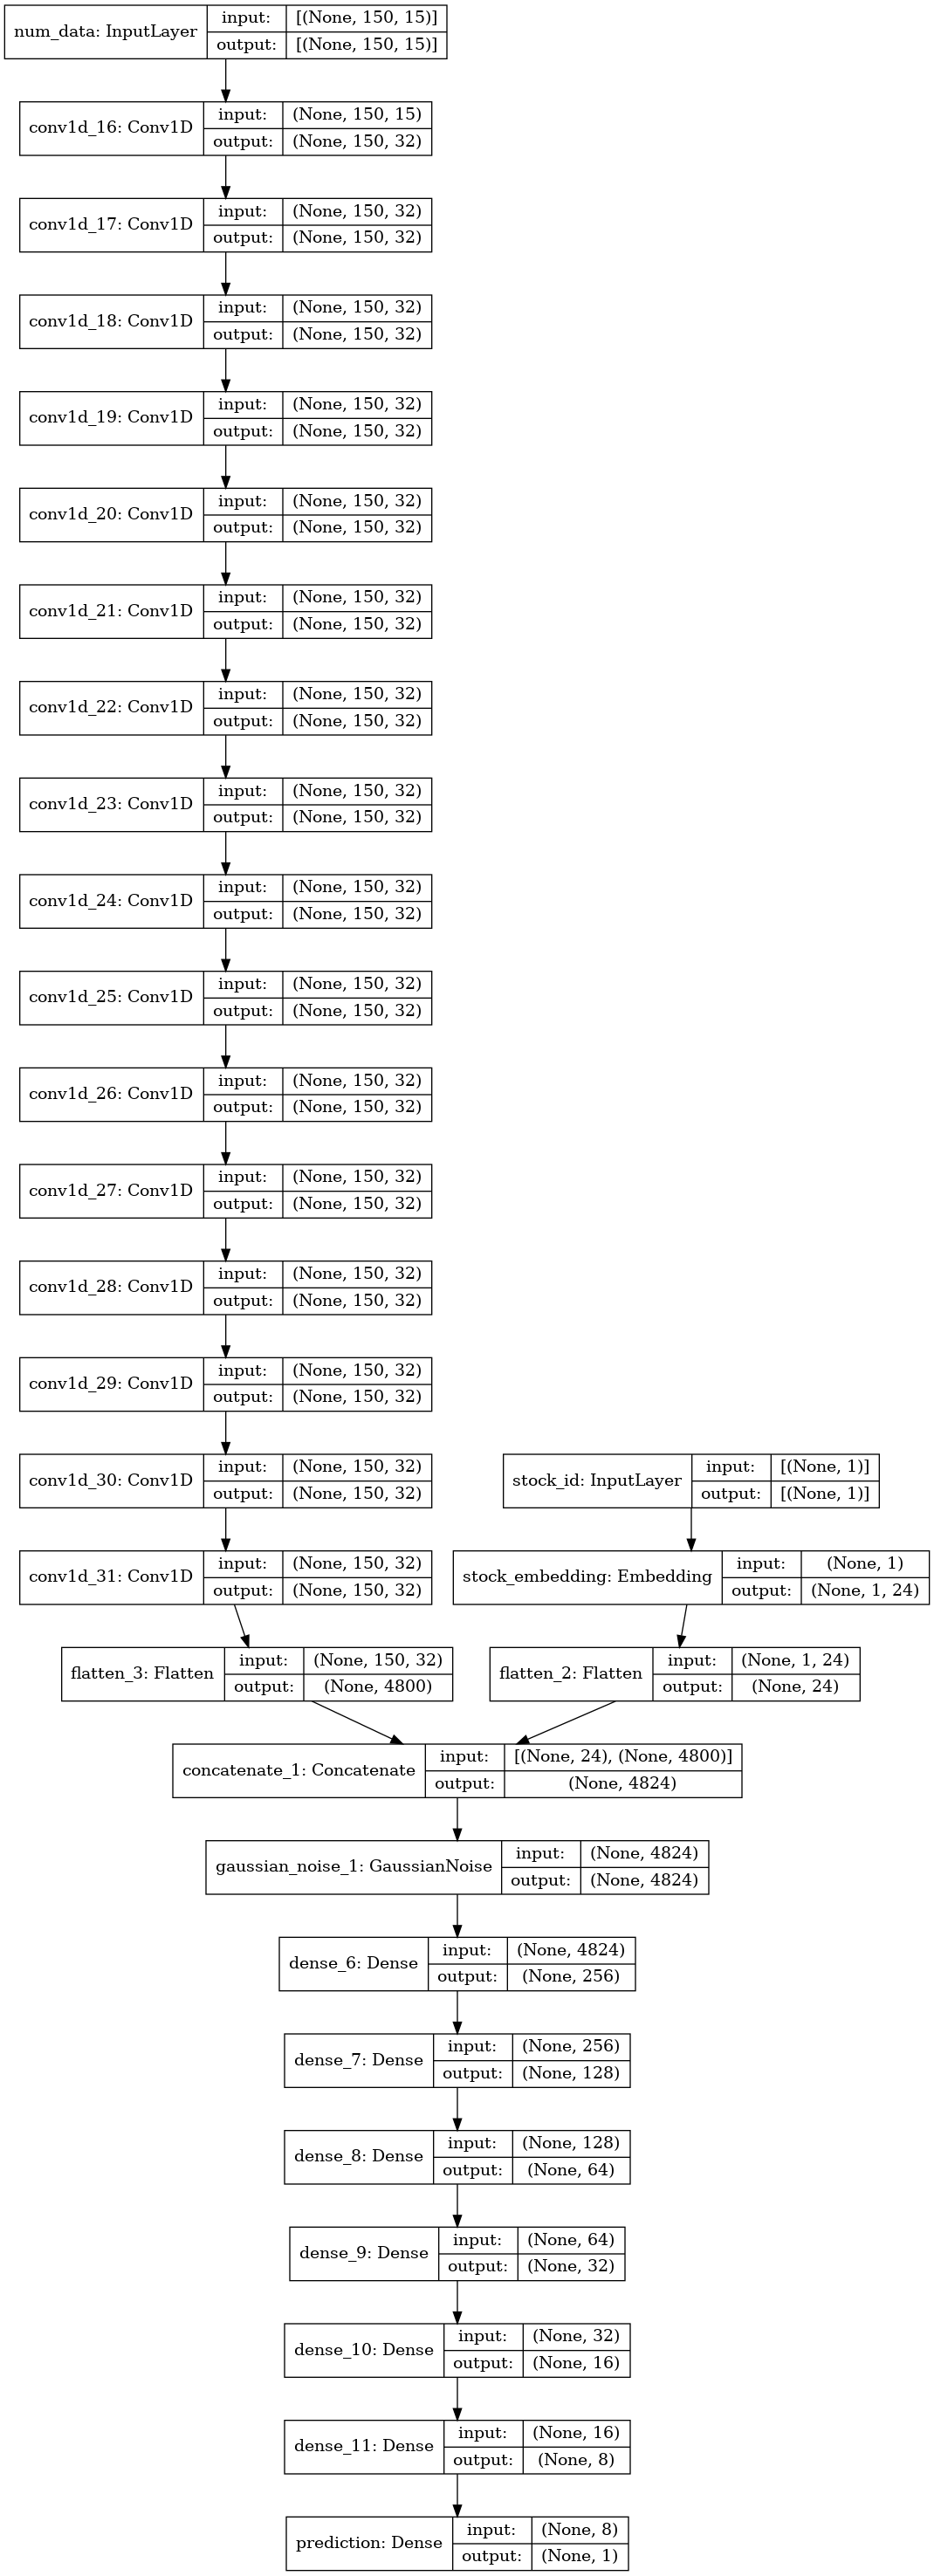

In [ ]:
from fastai.vision.all import *
from tqdm.notebook import  tqdm
from sklearn.preprocessing import QuantileTransformer
from sklearn import model_selection
from tensorflow import keras
from keras import backend as K
import tensorflow as tf
import gc
import warnings
warnings.filterwarnings("ignore")
import memory_profiler
m1 = memory_profiler.memory_usage()
PATH = Path('../input/optiver-realized-volatility-prediction')
data_dir = '../input/optiver-realized-volatility-prediction/book_train.parquet'

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [ ]:
def fix_offsets(data_df):
    offsets = data_df.groupby(['time_id']).agg({'seconds_in_bucket':'min'})
    offsets.columns = ['offset']
    data_df = data_df.join(offsets, on='time_id')
    data_df.seconds_in_bucket = data_df.seconds_in_bucket - data_df.offset
    return data_df

In [ ]:
def ffill(data_df):
    data_df=data_df.set_index(['time_id', 'seconds_in_bucket'])
    data_df = data_df.reindex(pd.MultiIndex.from_product([data_df.index.levels[0], np.arange(0,600)], names = ['time_id', 'seconds_in_bucket']), method='ffill')
    return data_df.reset_index()

In [ ]:
means = np.array([-0.0003,0.0003,0.077,0.0766,
                  -0.00052,0.0005,0.0959,0.0928,
                    6.85e-06,5.54e-06,6.44e-06,-6e-08,
                  0.000663,0.000197,
                    -0.0002
                 ]).astype('float16')

stds = np.array([0.00317,0.00317, 5.3541e-01, 4.9549e-01,
                 0.00317,0.00317, 6.6838e-01, 5.7353e-01,
                0.003,0.003,0.003,0.0003,
                 0.0007,0.00024,
                 0.00024
                ]).astype('float16')

In [ ]:
def load_data(fname):
    data = pd.read_parquet(fname)
    stock_id = str(fname).split('=')[1]
    time_ids = data.time_id.unique()
    row_ids = list(map(lambda x:f'{stock_id}-{x}', time_ids))
    data = fix_offsets(data)
    data = ffill(data)
    
    # Take every 4th second
    data = data.iloc[::4]
    
    data['wap1'] = (data['bid_price1'] * data['ask_size1'] +
                                            data['ask_price1'] * data['bid_size1']) / (data['bid_size1'] + data['ask_size1'])
    data['wap2'] = (data['bid_price2'] * data['ask_size2'] +
                                    data['ask_price2'] * data['bid_size2']) / (data['bid_size2'] + data['ask_size2'])
    data['wap'] = data['wap1']*0.7+data['wap2']*0.3

    
    data['log_return'] = data.groupby(by = ['time_id'])['wap'].apply(log_return).fillna(0)
    
    data['price_spread'] = (data['ask_price1'] - data['bid_price1']) / ((data['ask_price1'] + data['bid_price1']) / 2)
    data['bid_spread'] = data['bid_price1'] - data['bid_price2']
    data['ask_spread'] = data['ask_price1'] - data['ask_price2']

    # manipulating data to fit more accurate data into float16 type
    for i in ['bid_price1', 'ask_price1','bid_price2', 'ask_price2',
              'wap1','wap2','wap'
             ]:
        data[i] = data[i]-1
    
    # manipulating data to fit more accurate data into float16 type
    for i in ['bid_size1', 'ask_size1','bid_size2', 'ask_size2'
             ]:
        data[i] = data[i]/10000
        
    
    data = data[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1',
                 'bid_price2', 'ask_price2', 'bid_size2', 'ask_size2',
                'wap1','wap2','wap','log_return',
                 'price_spread','bid_spread','ask_spread'
                ]]
    
    cols = len(data.columns)
    data = data.to_numpy()
    data = (data - means) / stds
    data = data.reshape(len(time_ids),150,cols)
   
    return data, row_ids

In [ ]:
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')

In [ ]:
# Creating our training datasets

X = []
y = []
stocks = []
for i in os.listdir(data_dir)[:]:
    print(i)
    stockid = int(i.split('=')[-1])
    d = load_data(os.path.join(data_dir,i))
    
    # convert to float16 to reduce memory usage
    x_train = d[0].astype('float16')
    y_train = list(train['target'][train['stock_id']==stockid])
    stocks = stocks + [stockid]*len(x_train)
    
    if X==[]:
        X = x_train 
        y = y_train
    else:
        X = np.concatenate((X, x_train))
        y = np.concatenate((y, y_train))
    print(X.shape)
    del x_train
    gc.collect()
    
    # keeping track of memory usage
    m2 = memory_profiler.memory_usage()
    print(m2[0] - m1[0])

In [ ]:
scores_folds = {}
hidden_units = [256,128,64,32,16,8]
stock_embedding_size = 24
nb_features = X.shape[-1]

def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))

def base_model(window_size):
    
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(window_size,nb_features), name='num_data')
    
    stock_embedded = keras.layers.Embedding(127, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    
    conv = keras.layers.Conv1D(32,  kernel_size = (5), padding='same', activation='relu', input_shape=(window_size, nb_features))(num_input)
    for i in range(15):
        conv = keras.layers.Conv1D(32,  kernel_size = (5), padding='same', activation='relu', input_shape=(window_size, nb_features))(conv)
 
    conv = keras.layers.Flatten()(conv)
    
    out = keras.layers.Concatenate()([stock_flattened, conv])
    
    out = keras.layers.GaussianNoise(0.1)(out)
    
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, kernel_initializer='normal', activation='swish')(out)

    out = keras.layers.Dense(1, activation='swish', name='prediction')(out)#bias_initializer=tf.keras.initializers.Constant(value = mean_target)

    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model
gc.collect()
#tf.keras.utils.plot_model(base_model(150), to_file='model.png', show_shapes=True)

In [ ]:
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)


n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2020)
scores_folds[model_name] = []
counter = 1


es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-05, patience=6, verbose=1,
    mode='min')

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=4, verbose=1, min_lr=5e-7,
    mode='min')

# nothing fancy for the k-fold split, there was little improvement in grouping the split by time_ids 
# we stop after single fold here, but i would encourage you to experiment with more / different splits
for dev_index, val_index in kf.split(range(len(X))):
    
    if counter>1:
        break
    
    model = base_model(window_size=150)
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.0004), #0.0004
        loss='mean_squared_error',
        metrics=['MSE',root_mean_squared_per_error],
    )
    
    num_data = X[dev_index]
    cat_data = np.array(stocks)[dev_index]
    
    num_data_test = X[val_index]
    cat_data_test = np.array(stocks)[val_index]
    
    model.fit([cat_data, num_data], 
              y[dev_index], 
              sample_weight = 1/np.square(y[dev_index]),
              batch_size=256,
              epochs=100,
              validation_data=([cat_data_test, num_data_test], y[val_index], 1/np.square(y[val_index])),
              callbacks=[es, plateau],
              shuffle=True,
             verbose = 1)
    

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    def rmspe(y_true, y_pred):
        return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
    score = round(rmspe(y_true = y[val_index], y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    print(len(preds))
    
    counter += 1
gc.collect()


In [ ]:
def get_preds(data, model, stock_id):
    preds = model.predict([np.array([stock_id]*len(data)),data]).reshape(1,-1)[0]
    
    return preds

In [ ]:
test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')

data_dir = PATH/'book_test.parquet'
if len(test)<4:
    df_pred = pd.DataFrame()
    df_pred['row_id'] = list(test['row_id'])
    df_pred['target'] = [0,0,0]
    df_pred
else:
    all_preds = []
    for fname in tqdm(data_dir.ls()[:]):

        stock = int(str(fname).split('=')[-1])
        print(stock)
        
        data, row_ids = load_data(fname)
        preds = get_preds(data, model, stock)
        df_pred = pd.DataFrame(zip(row_ids, preds.tolist()),columns=['row_id', 'target'])
        all_preds.append(df_pred)
        
    df_pred = pd.concat(all_preds)

In [ ]:
df_pred.to_csv('submission.csv', index=False)